# Final Project : Spotify Popularity Trends
### Anna Cardinal and Claire Yegian


In [14]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import random

import mysklearn.myutils as myutils
import mysklearn.plotutils as plotutils
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.myclassifiers as myclassifiers
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyNaiveBayesClassifier, MyRandomForestClassifier

import mysklearn.myevaluation as myevaluation

We began our EDA by loading in our sampled and cleaned data.

In [4]:
spotify_table = MyPyTable()
spotify_table.load_from_file("./input_data/sampled_cleaned_spotify_tracks.csv")

We built a correlation plot using pandas in order to find the attributes that might be best to predict on.

In [5]:
df = pd.read_csv("./input_data/sampled_cleaned_spotify_tracks.csv")
corr_df = df.corr()
corr_df.style.background_gradient(cmap="coolwarm").set_precision(2)

/tmp/ipykernel_3524/1660192116.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient(cmap="coolwarm").set_precision(2)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
popularity,1.00,-0.04,0.15,0.14,0.13,-0.03,0.18,-0.03,0.04,-0.18,-0.17,-0.02,0.06,0.00,0.01
duration_ms,-0.04,1.00,-0.07,-0.18,0.09,0.00,0.05,0.02,-0.16,-0.07,0.02,-0.04,-0.17,0.02,-0.01
explicit,0.15,-0.07,1.00,0.19,0.07,-0.03,0.08,-0.03,0.35,-0.06,-0.07,0.04,0.07,0.02,0.03
danceability,0.14,-0.18,0.19,1.00,0.12,0.05,0.27,-0.14,0.23,-0.15,-0.24,-0.09,0.48,-0.11,0.22
energy,0.13,0.09,0.07,0.12,1.00,0.08,0.76,-0.13,0.15,-0.74,-0.34,0.21,0.37,0.20,0.17
key,-0.03,0.00,-0.03,0.05,0.08,1.00,0.05,-0.09,0.02,-0.08,-0.01,0.03,0.10,0.02,0.01
loudness,0.18,0.05,0.08,0.27,0.76,0.05,1.00,-0.11,0.12,-0.60,-0.58,0.14,0.30,0.24,0.20
mode,-0.03,0.02,-0.03,-0.14,-0.13,-0.09,-0.11,1.00,-0.06,0.12,0.01,-0.02,-0.10,-0.04,0.01
speechiness,0.04,-0.16,0.35,0.23,0.15,0.02,0.12,-0.06,1.00,-0.10,-0.10,0.06,0.17,0.16,0.06
acousticness,-0.18,-0.07,-0.06,-0.15,-0.74,-0.08,-0.60,0.12,-0.10,1.00,0.28,-0.14,-0.25,-0.17,-0.15


Looking at the popularity column, it looked like popularity has the highest correlations (in decending order) with acousticness, loudness, instrumentalness, explicit, danceability, and energy. We looked closer at these relationships. "Explicit" was in string format ("True" or "False") and had to be represented numerically (1=T 0=F) for the scatterplot, so we made a new list to track and graph the numeric representation of "explicit".

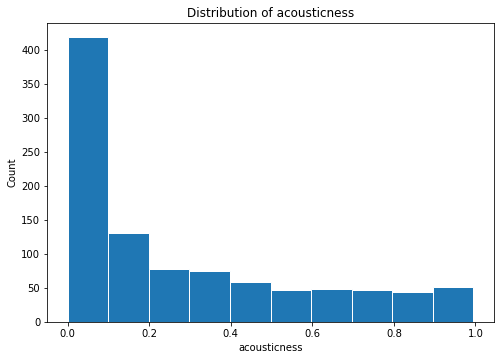

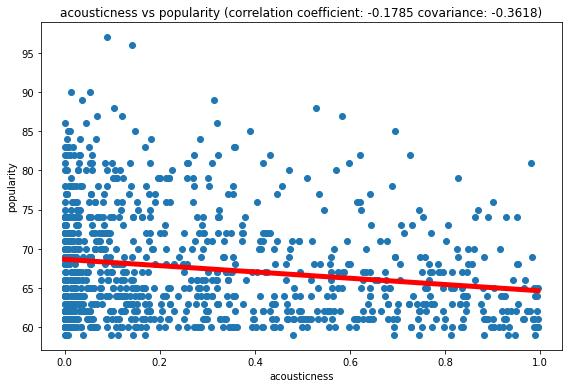

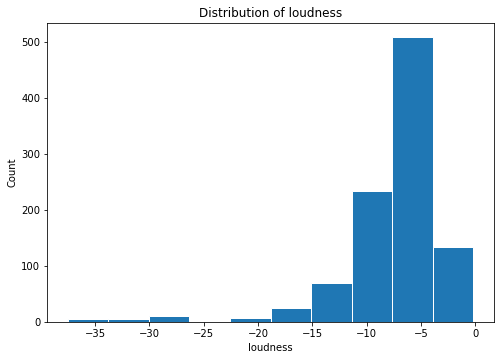

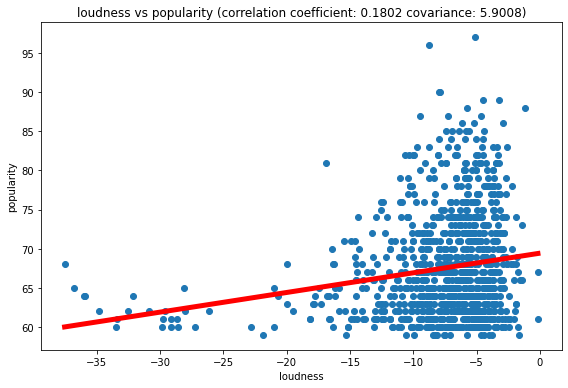

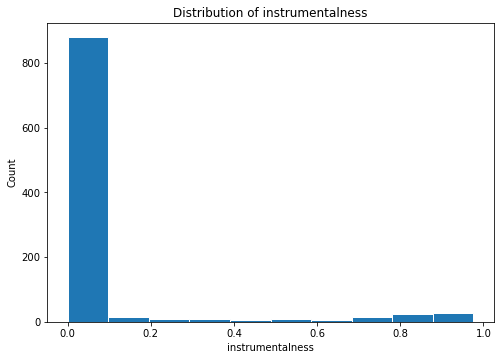

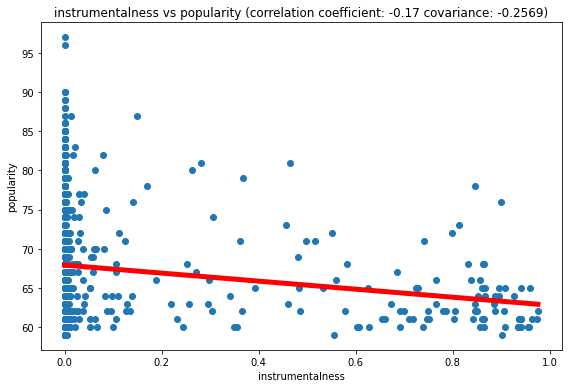

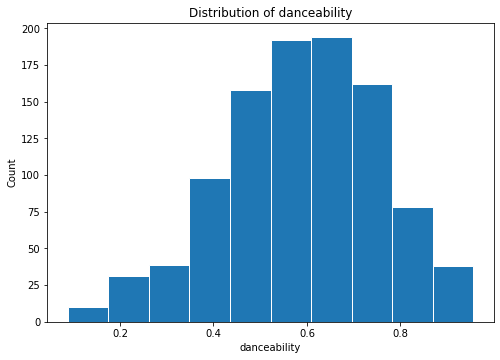

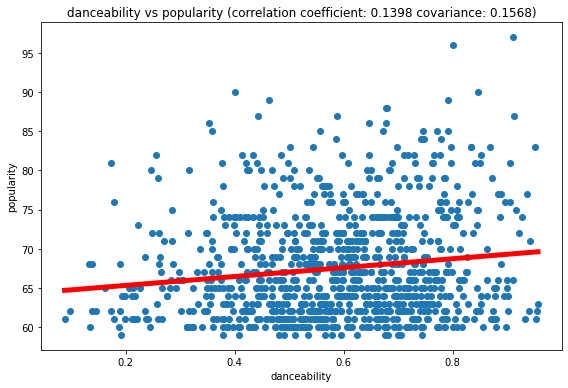

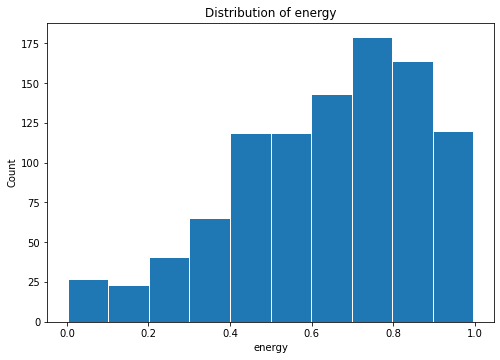

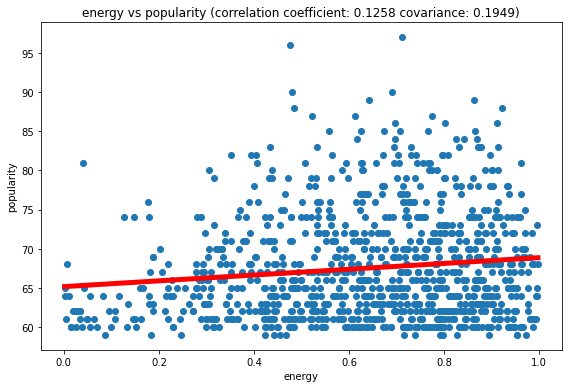

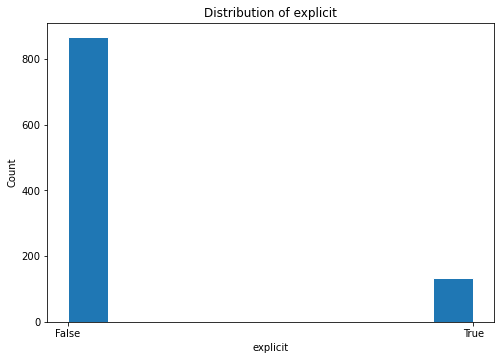

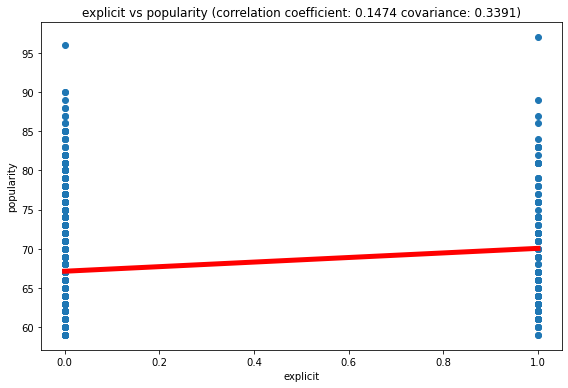

In [6]:
importlib.reload(myutils)
importlib.reload(plotutils)

explicit_col = spotify_table.get_column("explicit")
explicit_nums = []
for value in explicit_col:
    if value == "True":
        explicit_nums.append(1)
    else:
        explicit_nums.append(0)

attributes = ["acousticness", "loudness", "instrumentalness", "danceability", "energy"]
for attbt in attributes:
    plotutils.histogram(spotify_table, attbt, attbt)
    plotutils.scatter_plot(spotify_table, attbt, "popularity")
# explicit column had to be handled separately because it was in string form
plotutils.histogram(spotify_table, "explicit", "explicit")
plotutils.scatter_plot(spotify_table, explicit_nums, spotify_table.get_column("popularity"), labels=["explicit", "popularity"])

Based on the above graphs, acousticness, loudness, and instrumentalness had the most correlation with popularity (correlation coefficients of +/- 0.17 or 0.18) followed by explicit, danceability, and energy (correlation coefficients of 0.12 - 0.15). After looking at these relationships, we were prepared to discretize our data in order to make it useable for our random forest classifier, which can't handle continuous data.

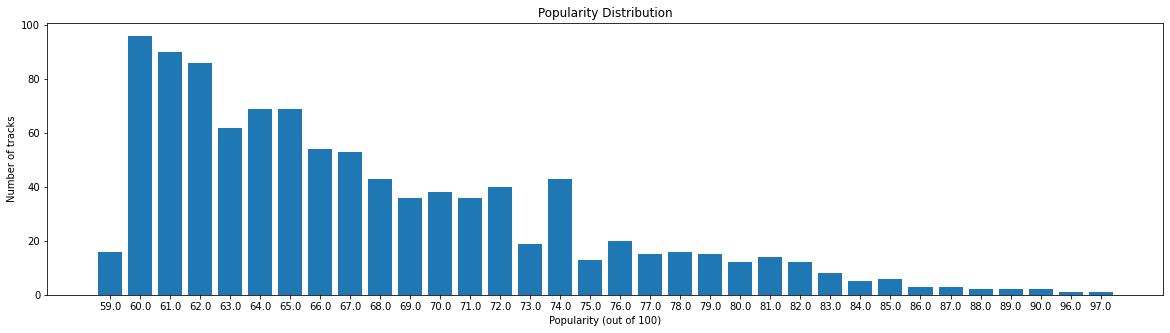

In [7]:
importlib.reload(myutils)

popularity_column = spotify_table.get_column("popularity")
unique_popularities = sorted(myutils.get_unique_values(popularity_column))
frequencies = myutils.get_frequency_of_multiple_values(unique_popularities, popularity_column)
plotutils.simple_bar_chart(unique_popularities, frequencies, ["Popularity (out of 100)", "Number of tracks", "Popularity Distribution"])

The popularity distribution was skewed, so we decided to just divide it into four classes ("least popular", "less popular", "popular", "very popular") of equal size. Since the cutoffs for each category were whole numbers, it didn't divide perfectly, but the discretization did make the popularity distribution much more even.

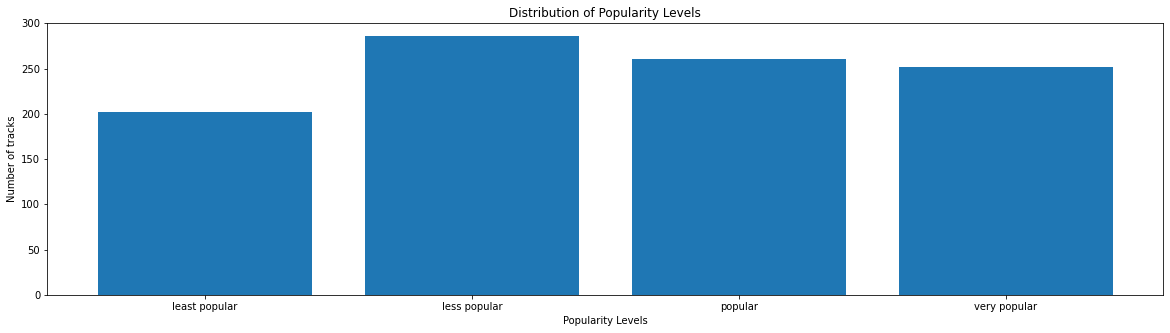

In [8]:
importlib.reload(myutils)

cutoffs = myutils.compute_equal_frequency_cutoffs(sorted(popularity_column), 4)
discretized_popularities = myutils.discretize_with_cut_offs(popularity_column, cutoffs, ["least popular", "less popular", "popular", "very popular"])

unique_discretized_popularities = sorted(myutils.get_unique_values(discretized_popularities))
frequencies_discretized_popularities = myutils.get_frequency_of_multiple_values(unique_discretized_popularities, discretized_popularities)
plotutils.simple_bar_chart(unique_discretized_popularities, frequencies_discretized_popularities, ["Popularity Levels", \
    "Number of tracks", "Distribution of Popularity Levels"])

We then used the same method (dividing into four equal-sized categories) to discretize acousticness, loudness, instrumentalness, danceability, and energy

In [9]:
importlib.reload(myutils)

selected_attributes = ["acousticness", "loudness", "instrumentalness", "danceability", "energy"]
data_columns = []
for attr in selected_attributes:
    data_column = spotify_table.get_column(attr)
    data_columns.append(data_column)

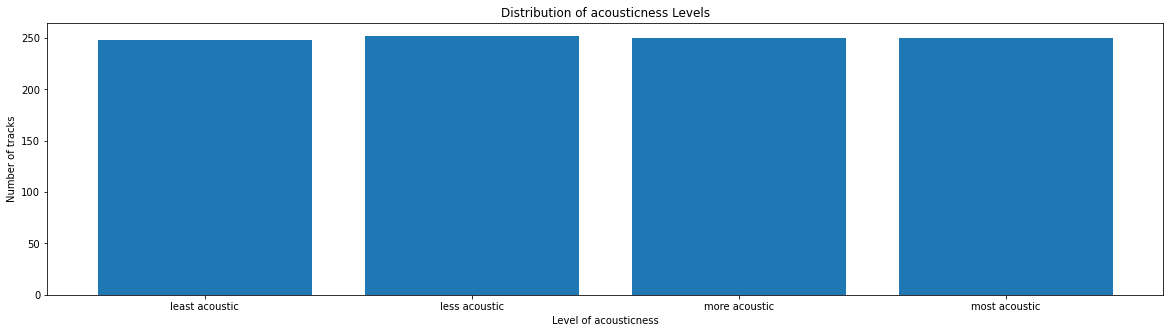

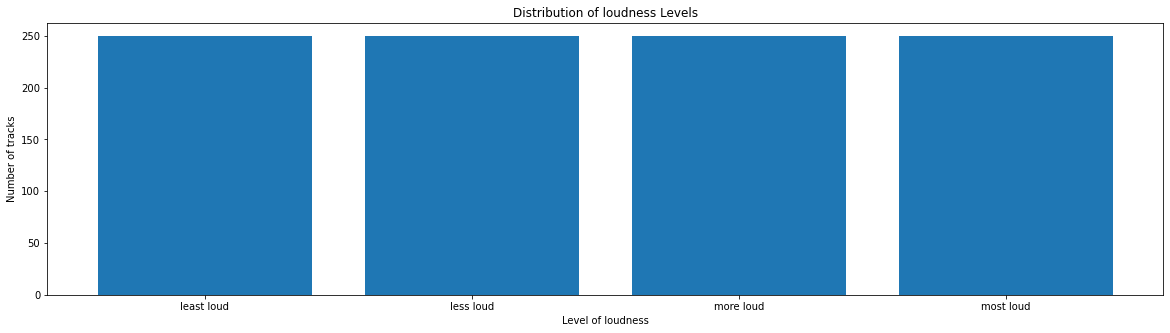

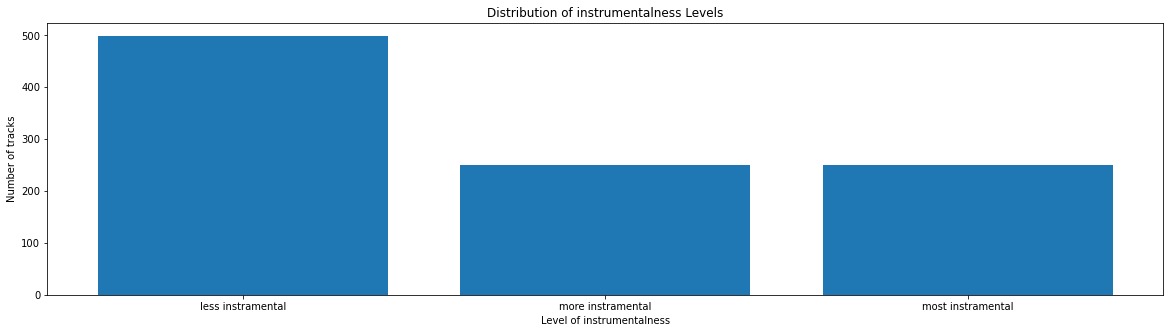

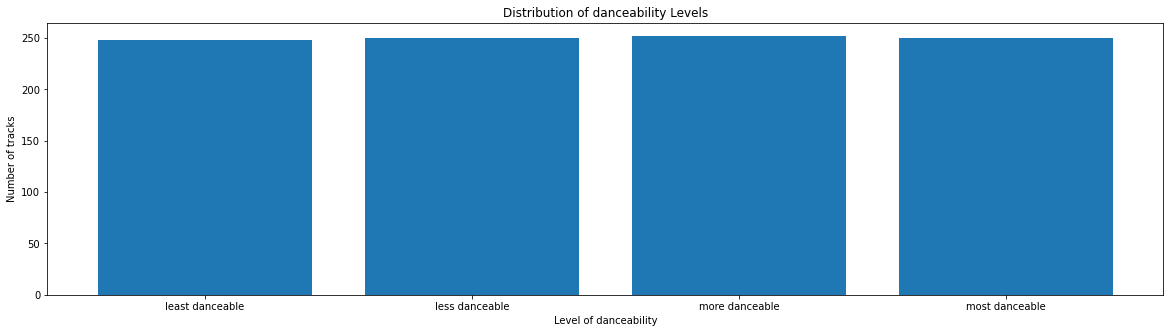

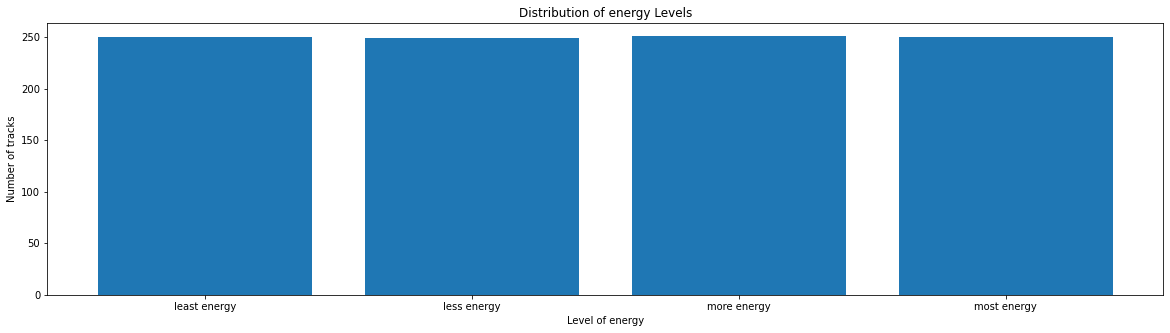

In [10]:
importlib.reload(myutils)

discretized_data_columns = []
selected_attributes_names = ["acoustic", "loud", "instramental", "danceable", "energy"]
for index, column in enumerate(data_columns):
    cutoffs = myutils.compute_equal_frequency_cutoffs(sorted(column), 4)
    discretized_values = myutils.discretize_with_cut_offs(column, cutoffs, [f"least {selected_attributes_names[index]}", f"less {selected_attributes_names[index]}", f"more {selected_attributes_names[index]}", f"most {selected_attributes_names[index]}"])
    discretized_data_columns.append(discretized_values)
    unique_discretized_values = sorted(myutils.get_unique_values(discretized_values))
    frequencies_discretized_values = myutils.get_frequency_of_multiple_values(unique_discretized_values, discretized_values)
    plotutils.simple_bar_chart(unique_discretized_values, frequencies_discretized_values, [f"Level of {selected_attributes[index]}", \
    "Number of tracks", f"Distribution of {selected_attributes[index]} Levels"])

The distributions of the attributes were all quite even after discretization. You'll notice that instrumentalness has only three categories. That attribute had a very strong skew prior to discretization, which was best handled by eliminating one of the categories.

With discretized data, we were ready to build and evaluate three classifiers (naive bayes, K nearest neighbors, and random forest) on our sampled and cleaned data.

In [11]:
importlib.reload(myutils)
importlib.reload(myclassifiers)

X_data = []
for index in range(len(discretized_data_columns[0])):
    instance = []
    for column in discretized_data_columns:
        instance.append(column[index])
    X_data.append(instance)
print(X_data[:10])
all_nb_predictions, all_knn_predictions, all_forest_predictions, y_actual = [], [], [], []
nb_clf, knn_clf, forest_clf = MyNaiveBayesClassifier(), MyKNeighborsClassifier(), MyRandomForestClassifier()
skfold_splits = myutils.strat_cross_val_predict(10, X_data, discretized_popularities, 10)
for skfold_split in skfold_splits:
    for split in skfold_split:
        nb_clf.fit(split[0], split[2])
        knn_clf.fit(split[0], split[2])
        forest_clf.fit(split[0], split[2])
        nb_predictions, knn_predictions, forest_predictions = nb_clf.predict(split[1]), knn_clf.predict(split[1]), forest_clf.predict(split[1])
        y_actual += split[3]
        all_nb_predictions += nb_predictions
        all_knn_predictions += knn_predictions
        all_forest_predictions += forest_predictions 

[['least acoustic', 'most loud', 'most instramental', 'least danceable', 'most energy'], ['most acoustic', 'least loud', 'more instramental', 'least danceable', 'least energy'], ['most acoustic', 'least loud', 'less instramental', 'least danceable', 'least energy'], ['least acoustic', 'most loud', 'most instramental', 'less danceable', 'most energy'], ['more acoustic', 'least loud', 'less instramental', 'more danceable', 'less energy'], ['least acoustic', 'less loud', 'more instramental', 'least danceable', 'more energy'], ['least acoustic', 'most loud', 'less instramental', 'least danceable', 'most energy'], ['most acoustic', 'less loud', 'less instramental', 'most danceable', 'less energy'], ['less acoustic', 'more loud', 'less instramental', 'less danceable', 'less energy'], ['more acoustic', 'less loud', 'more instramental', 'more danceable', 'more energy']]


In [12]:
importlib.reload(myutils)

print("=====================================================================")
print(f"Naive Bayes Classifier: \n\taccuracy = {myevaluation.accuracy_score(y_actual, nb_predictions, True):.3}, error rate = {1 - myevaluation.accuracy_score(y_actual, nb_predictions, True):.3} \
    \n\tprecision rate = {myevaluation.binary_precision_score(y_actual, nb_predictions):.3}\
, recall = {myevaluation.binary_recall_score(y_actual, nb_predictions):.3}\
, F1 = {myevaluation.binary_f1_score(y_actual, nb_predictions):.3}")
print("=====================================================================")
print(f"kNN Classifier: \n\taccuracy = {myevaluation.accuracy_score(y_actual, knn_predictions, True):.3}, error rate = {1 - myevaluation.accuracy_score(y_actual, knn_predictions, True):.3} \
    \n\tprecision rate = {myevaluation.binary_precision_score(y_actual, knn_predictions):.3}\
, recall = {myevaluation.binary_recall_score(y_actual, knn_predictions):.3}\
, F1 = {myevaluation.binary_f1_score(y_actual, knn_predictions):.3}")
print("=====================================================================")
print(f"Random Forest Classifier: \n\taccuracy = {myevaluation.accuracy_score(y_actual, forest_predictions, True):.3}, error rate = {1 - myevaluation.accuracy_score(y_actual, forest_predictions, True):.3} \
    \n\tprecision rate = {myevaluation.binary_precision_score(y_actual, forest_predictions):.3}\
, recall = {myevaluation.binary_recall_score(y_actual, forest_predictions):.3}\
, F1 = {myevaluation.binary_f1_score(y_actual, forest_predictions):.3}")
print("=====================================================================")

Naive Bayes Classifier: 
	accuracy = 0.39, error rate = 0.61     
	precision rate = 0.342, recall = 0.464, F1 = 0.394
kNN Classifier: 
	accuracy = 0.27, error rate = 0.73     
	precision rate = 0.345, recall = 0.357, F1 = 0.351
Random Forest Classifier: 
	accuracy = 0.39, error rate = 0.61     
	precision rate = 0.364, recall = 0.857, F1 = 0.511


## Classification Results: 
We decided to run naive bayes, k nearest neighbors, and random forest because they are our "smartest" (most complex) classifiers. All three are designed with fit and predict methods, based on sklearn's classifiers.

We built our random forest classifier by selecting F (we used our classifier default of 2) random attributes to split on, the factor that would "randomize" our forrest. We used the bootstrap method to create a train/test split, and then we built, fit, and scored each of our N (default 20 trees. We saved our M (default 7) best trees as an attribute of our classifier object. In order to predict on our classifier, we obtained predictions for each test instance from each tree. We then took the majority vote from the predictions from each tree and saved that as our final prediction for that instance.

When evaluating our classifiers, we focused on accuracy and error rate instead of precision and recall. We wanted to emphasize correct selection over "positive" and "negative" classfication, which are more fitting measures for binary classifiactions.


The classifiers had pretty low accuracies, high error rates, and low precision, recall, and F1 scores. From the beginning (see correlation matrix), we saw very low correlations (the highest being 0.18) between popularity and the other attributes of songs. This explains why our classifiers did not perform very well. Although all of the three classifiers we used–naive bayes, k nearest neighbors, and random forest–performed poorly, the random forrest classifier performed the best (F1: 51%), while naive bayes followed closely behind (F1: 39%), and k nearest neighbors performed the worst (F1: 35%).

In [40]:
def print_confusion_matrix(actual, preds_list):
    headers = ["least popular", "less popular", "popular", "very popular"]
    print("===========================================\n \
    Confusion Matricies\n \
    ===========================================")
    for classifier in preds_list:
        predictions = classifier[1]
        print(classifier[0], "classifier: (Stratified 10-Fold Cross Validation Results)")
        print(tabulate(myutils.cm_table(actual, predictions, headers), headers))

In [41]:
importlib.reload(myutils)

preds_list = [("Naive Bayes", all_nb_predictions), ("K Nearest Neighbors", all_knn_predictions), ("Random Forest", all_forest_predictions)]
print_confusion_matrix(y_actual, preds_list)

     Confusion Matricies
Naive Bayes classifier: (Stratified 10-Fold Cross Validation Results)
                 least popular    less popular    popular    very popular
-------------  ---------------  --------------  ---------  --------------
least popular              260             820        190             750
less popular               470             910        300            1180
popular                    300             800        170            1330
very popular                80             650        280            1510
K Nearest Neighbors classifier: (Stratified 10-Fold Cross Validation Results)
                 least popular    less popular    popular    very popular
-------------  ---------------  --------------  ---------  --------------
least popular              920             730        240             130
less popular              1220             960        490             190
popular                   1160             830        340             270
very popular 

Some attributes were more closely correlated to each other than they were to popularity (again, see correlation matrix). One of these strong relationships was between loudness and energy. We plotted that relationship in order to visualize the stronger correlation, which was reflected in their much higher correlation coefficient of 0.76.

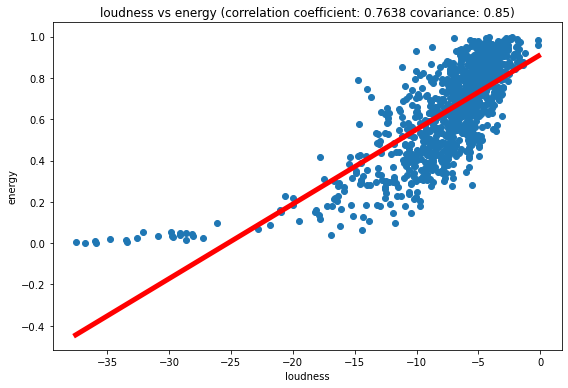

In [22]:
plotutils.scatter_plot(spotify_table, "loudness", "energy")

## Conclusion: 

The Spotify dataset we used had many interesting measures of different characteristics for 114,000 tracks on the music streaming site. These included measures of sound type, energy, and classifications like genre. The data was pretty useable except that all attributes needed to be discretized before being useable for a decision tree. We used a correlation matrix to identify the best attributes for classification, and then further analyzed those with histograms and scatter plots before using them in our naive bayes, k nearest neighbors, and random forest classifiers. We did briefly explore the idea of including track genre in our classifiers, thinking it might be a good predictor. We found that there were so many genres that it probably wouldn't have much of a predictive impact on our classifier, and after attempting to descretize track_genre, we realized it probably wasn't worth our effort. 

Of the classifiers, random forest performed the best, but only slightly better than naive bayes and k nearest neighbors. K nearest neighbors did not necesarily need to be discretized and may have performed better had it not been. The classifiers as a whole may have been better if we had found a way to include artist and/or genre, but we doubt that considering how many unique values each of those attributes had. It is possible that these attributes are simply not great for predicting the popularity of songs, or maybe the popularity of songs is more random than we thought.